In [1]:
import pymysql
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dtt
import statsmodels.api as sm
from matplotlib.ticker import  MultipleLocator
from matplotlib.ticker import  FormatStrFormatter

In [2]:
class Data(object):
    """本类用于从mysql中提取相应条件的数据"""
    def __init__(self, sql, cur, args=None):
        self.sql = sql
        self.cur = cur
        self.args = args
        self.data = Data.get_data(self)

    def __str__(self):
        return str(self.data)

    __repr__ = __str__

    def get_data(self):
        _ = self.cur.execute(self.sql, self.args)
        data = self.cur.fetchall()
        return data

    def select_col(self, col):
        return [d[col] for d in self.data]

In [3]:
db = pymysql.connect("localhost", "root", "root", "strategy1", charset="utf8")
cur = db.cursor()

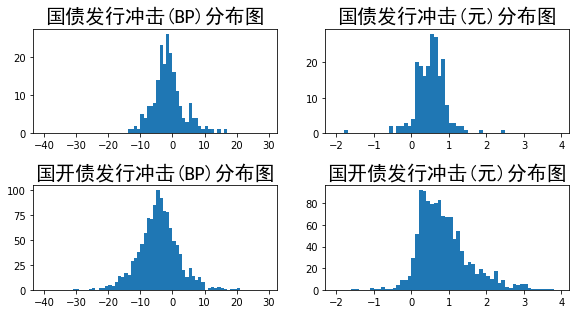

In [4]:
# 绘制国债与国开债地发行冲击分布图（分别以bp和元表示价格冲击）
fig, axes = plt.subplots(2, 2, figsize=(9.6, 4.8))
fig.subplots_adjust(hspace=0.5)
i = 0
for bondtype in ["00", "02"]:
    j = 0
    for column in ["delta", "dprice"]:         
        sql = r"select {0} from tb_sec_delta where seq = 0 and {0} is not null and code0 regexp '[:alnum:]{{2}}{1}.*'".format(column, bondtype)
        imp = np.array(Data(sql, cur).select_col(0))
        if column == "delta":
            if bondtype == "00":
                bins = np.arange(-40, 30, 1)
                title = "国债发行冲击(BP)分布图"
            elif bondtype == "02":
                bins = np.arange(-40, 30, 1)
                title = "国开债发行冲击(BP)分布图"
            else:
                raise ValueError("错误的参数值bondtype")
        elif column == "dprice":
            if bondtype == "02":
                bins = np.arange(-2, 4, 0.1)
                title = "国开债发行冲击(元)分布图"
            elif bondtype == "00":                
                bins = np.arange(-2, 4, 0.1)
                title = "国债发行冲击(元)分布图"
            else:
                raise ValueError("错误的参数值bondtype")
        else:
            raise ValueError("错误的参数值column")
        axes[i, j].hist(imp, bins=bins)
        axes[i, j].set_title(title, fontproperties="SimHei", fontsize=20)
        j += 1
    i += 1

In [5]:
 def get_avg_std_by_term(cur, terms, bond_type=None, column="delta"):
        """计算不同期限的发行冲击的均值与标准差"""
        res = []
        if bond_type is None:
            sql = "select count(*), avg({0}), stddev_samp({0}) from tb_sec_delta where seq = 0 and term = %s".format(column)
        else:
            sql = """select count(*), avg({0}), stddev_samp({0}) from tb_sec_delta where seq = 0 and term = %s 
            and code regexp '[:alnum:]{{2}}{1}.*' and dt > '2016-4-1'""".format(column, bond_type)
        for t in terms:
            num, avg, std = Data(sql, cur, (t,)).data[0]
            res.append([num, avg, std])
        return res

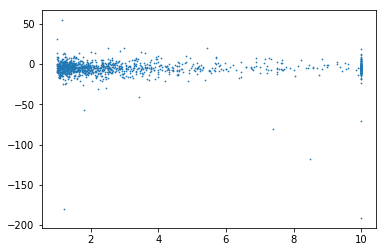

In [6]:
# 绘制债券发行乘数与发行冲击的散点图
sql = r"""select t1.mg_multiplier, t2.delta from tb_pri t1 
inner join tb_sec_delta t2 on t1.code = t2.code and t2.seq = 0
where bond_type = '国开债'"""
data = Data(sql, cur)
x = np.array(data.select_col(0))
y = np.array(data.select_col(1))
fig, ax = plt.subplots(1, 1)
ax.scatter(x, y, s=0.5)

In [74]:
# 债市周期与发行冲击

bondtype = "02"  # 债券种类：国开债（02） or 国债（00）

dts = [dtt.date(2013, 6, 20), dtt.date(2013, 11, 20), dtt.date(2014, 11, 11), dtt.date(2015, 7, 2), dtt.date(2016, 1, 13), 
       dtt.date(2016, 10, 28), dtt.date(2018, 1, 19), dtt.date(2018, 8, 3)]     # 牛熊分界点（粗略估计）

sql = """select avg(delta), stddev_samp(delta), count(*) from tb_sec_delta
where seq = 0 and dt > %s and dt <= %s and code regexp '[:alnum:]{{2}}{}.*'""".format(bondtype)

res = []
for i in range(len(dts)-1):
    data = Data(sql, cur, (dts[i], dts[i+1])).data
    res.append(data[0])

In [8]:
# 债市周期、债券期限与发行冲击

bondtype = "00"
terms = [1, 2, 3, 5, 7, 10]
dts = [dtt.date(2013, 6, 20), dtt.date(2013, 11, 20), dtt.date(2014, 11, 11), dtt.date(2015, 7, 2), dtt.date(2016, 1, 13), 
       dtt.date(2016, 10, 28), dtt.date(2018, 1, 19), dtt.date(2018, 8, 3)]     # 牛熊分界点（粗略估计）


sql1 = """select avg(delta), count(*) from tb_sec_delta 
where seq = 0 and dt > %s and dt <= %s and code regexp '[:alnum:]{{2}}{}.*'
and term = %s""".format(bondtype)

res = []

for i in range(len(dts)-1):
    r = []
    for t in terms:
        d = Data(sql1, cur, (dts[i], dts[i+1], t)).data[0]
        r.append(d)
    res.append(r)   

In [10]:
for r1 in res:
    print()
    for r2 in r1:
        print()
        for r3 in r2:
            print(r3, end="  ")



None  0  
None  0  
4.46999979  1  
10.85999966  1  
5.88666677  3  
4.37000002  3  

None  0  
None  0  
-0.48666668  3  
-7.97000011  3  
-3.44714281  7  
-5.33499994  6  

None  0  
None  0  
-4.14500004  2  
-1.26333332  3  
-0.48499999  6  
-2.05599998  5  

None  0  
10.06000042  1  
-3.46749997  4  
-2.41750002  4  
-2.07999998  4  
-2.01799998  5  

-0.85833335  6  
-0.95333335  3  
-5.03833329  6  
-4.37999989  6  
0.80000003  7  
-1.23499997  6  

3.50199997  10  
0.53750002  4  
-0.99799999  10  
-0.83500003  10  
-1.73222223  9  
-1.75800004  10  

-1.56999999  4  
-0.80499998  2  
-3.88000002  5  
-4.03249994  4  
-3.67833333  6  
-4.36500007  4  

In [58]:
# 发行规模与发行冲击

bondtype = "00"  # 债券种类：国开债（02） or 国债（00）

# 将发行规模五等分，分位数存储于per_amount
sql1 = """select t1.amount, t2.delta from appendix1 t1 inner join tb_sec_delta t2 
on t1.code = t2.code and t2.seq = 0
where t1.code regexp '[:alnum:]{{2}}{}.*'""".format(bondtype)
data = Data(sql1, cur).data
data = np.array(data)
data = pd.DataFrame(data, columns=['amount', 'delta'])
per_amount = [0]
for p in range(20, 120, 20):
    per_amount.append(float(np.percentile(data["amount"], p)))
    
# 计算每个分位之间的delta均值
res = []
sql2 = """select avg(t2.delta), count(*) from  appendix1 t1 inner join tb_sec_delta t2 
on t1.code = t2.code and t2.seq = 0
where t1.amount > %s and t1.amount <= %s and t1.code regexp '[:alnum:]{{2}}{}.*'""".format(bondtype)
for i in range(len(per_amount)-1):
    d = Data(sql2, cur, (per_amount[i], per_amount[i+1])).data
    res.append(d[0])

In [67]:
for r in res:
    print(r)

(5.76249998, 2.9094022069519125, 297.375004, 8)
(-4.28999998, 5.13443926849149, 280.526316, 19)
(-1.579375, 4.8458979492761065, 264.312502, 16)
(-1.77166663, 3.4902693185494824, 283.388889, 18)
(-1.36368418, 5.090139591783868, 310.507894, 38)
(0.14448273, 4.741611669466564, 293.715517, 58)
(-3.10928572, 3.4017739653009267, 321.075, 28)


In [13]:
class ImpFuture(object):
    """用于统计发行冲击后的国债期货表现"""
    def __init__(self, cur, db):
        self.cur = cur
        self.db = db

    def imp_days(self, bond_type, future_type):
        """将发行冲击五等分，计算之后4日的国债期货收益均值，参数bond_type为续发债类型，分别为
        国债和国开债，future_type为国债期货合约类型("TF"或者"T")"""
        if future_type == "TF":
            future_term = 5
        elif future_type == "T":
            future_term = 10
        else:
            raise ValueError("不被接受的参数值future_term")
        sql1 = """select t1.delta, t2.dsrate, t3.dsrate, t4.dsrate, t5.dsrate
        from impact t1 inner join future_delta t2 inner join future_delta t3
        inner join future_delta t4 inner join future_delta t5
        on t1.dt = t2.dt and t3.seq = t2.seq + 1 and t4.seq = t3.seq+1 and t5.seq = t4.seq+1
        and t3.term = t2.term and t4.term = t3.term and t5.term = t4.term
        and t1.bondtype = %s and t2.term = %s
        order by t1.delta
        """
        data = Data(sql1, self.cur, (bond_type, future_term)).data
        data = pd.DataFrame(np.array(data), columns=["delta", "first", "second", "third", "fourth"])
        # 依据delta将data五等分
        n = 5
        res = []
        l = int(len(data)/n)
        for i in range(n):
            a = i*l
            b = (i+1)*l-1
            if i == 4:
                b = -1
            d = list(data[a:b].mean())
            d.insert(1, len(data[a:b]))
            res.append(d)
        return res

    def imp_minutes(self, bond_type, future_type, day=0):
        """计算发行冲击当日的五分钟级的市场走势"""
        if future_type == "TF":
            future_term = 5
        elif future_type == "T":
            future_term = 10
        else:
            raise ValueError("不被接受的参数值future_type")
        # 获得delta五等分点
        sql1 = """select t1.delta from impact t1 inner join future_minute t2
                  on t1.dt = date(t2.dtt) and t2.seq=0
                  where t1.bondtype = %s and t2.term = %s
                  """
        delta = np.array(Data(sql1, self.cur, (bond_type, future_term)).data)
        delta = pd.DataFrame(delta, columns=["delta"]).dropna()
        per_delta = [float(delta.min()-1)]
        for p in range(20, 120, 20):
            per_delta.append(float(np.percentile(delta, p)))
        # 根据五等分点（per_delta)从数据库中选出每个分位的
        data = []
        if day == 0:
            sql2 = r"""select date_format(t2.dtt, '%%H:%%i'), avg(t2.rate) from impact t1 
            inner join future_minute t2
            on t1.dt = date(t2.dtt) and t1.bondtype = %s and t2.term = %s 
            and t1.delta > %s and t1.delta <= %s
            group by date_format(t2.dtt, '%%H:%%i')"""
        elif day > 0:
            sql2 = r"""select date_format(t2.dtt, '%%H:%%i'), avg(t2.rate) from impact t1 
            inner join future_minute t2 inner join dts1 t3 inner join dts1 t4
            on t1.dt = t3.dt and t4.seq = t3.seq +{} and t4.dt = date(t2.dtt)
            where t1.bondtype = %s and t2.term = %s and t1.delta > %s and t1.delta <= %s
            group by date_format(t2.dtt, '%%H:%%i')
            """.format(day)
        else:
            sql2 = r"""select date_format(t2.dtt, '%%H:%%i'), avg(t2.rate) from impact t1 
            inner join future_minute t2 inner join dts1 t3 inner join dts1 t4
            on t1.dt = t3.dt and t4.seq = t3.seq - {} and t4.dt = date(t2.dtt)
            where t1.bondtype = %s and t2.term = %s and t1.delta > %s and t1.delta <= %s
            group by date_format(t2.dtt, '%%H:%%i')
            """.format(abs(day))
        for i in range(len(per_delta)-1):
            a = per_delta[i]
            b = per_delta[i+1]
            da = Data(sql2, self.cur, (bond_type, future_term, a, b))
            time_index = da.select_col(0)
            rate = da.select_col(1)
            data.append(rate)
        data = np.array(data).T
        res = []
        for k in range(1, len(data), 1):
            res.append(100*(data[k] - data[0]))
        res = pd.DataFrame(res, index=time_index[1:], columns=["一", "二", "三", "四", "五"])
        return res

    def imp_minutes_plot(self, day=0):
        """将利率债发行对国债期货市场的影响可视化，即分别以国债-TF、国债-T、国开债-TF、国开债-T作为参数
        计算imp_minutes，并将结果放入一张4×1的图中"""
        imp_minutes_params = [("国债", "TF"), ("国债", "T"), ("国开债", "TF"), ("国开债", "T")]
        fig, axes = plt.subplots(4, 1, figsize=(8,12), sharex="all", )
        xmajorLocator = MultipleLocator(4)
        for params, ax in zip(imp_minutes_params, axes):
            data =  self.imp_minutes(*params, day)
            ax.spines["top"].set_color("none")
            ax.spines["right"].set_color("none")
            ax.xaxis.set_ticks_position("bottom")
            ax.yaxis.set_ticks_position("left")
            labels = ["一", "二", "三", "四", "五"]
            for i in range(len(labels)):
                ax.plot(data.index, data.iloc[:, i], label=labels[i])
            ax.spines["bottom"].set_position(('data', 0))
            ax.xaxis.set_major_locator(xmajorLocator)
            ax.set_title("{}-{}".format(*params))
            ax.legend(loc="best")
        fig.show()

In [15]:
imp_future = ImpFuture(cur, db)
data = imp_future.imp_days("国债", "TF")
data

[[-0.07194137931034485,
  37,
  -1.9735135135135127,
  -0.8872972972972972,
  -0.5559459459459458,
  0.5102702702702704],
 [0.01587837837837838,
  37,
  0.2178378378378379,
  0.205945945945946,
  -0.25702702702702707,
  1.2075675675675677],
 [0.0709972972972973,
  37,
  2.1943243243243242,
  -0.6648648648648648,
  -0.6494594594594596,
  1.5129729729729728],
 [0.26204594594594594,
  37,
  0.5589189189189191,
  -0.9059459459459462,
  -1.6597297297297295,
  0.14054054054054063],
 [0.6442052631578946,
  38,
  0.07657894736842108,
  -0.17710526315789465,
  -1.5042105263157894,
  -0.5778947368421052]]

NameError: name 'xmajorLocator' is not defined

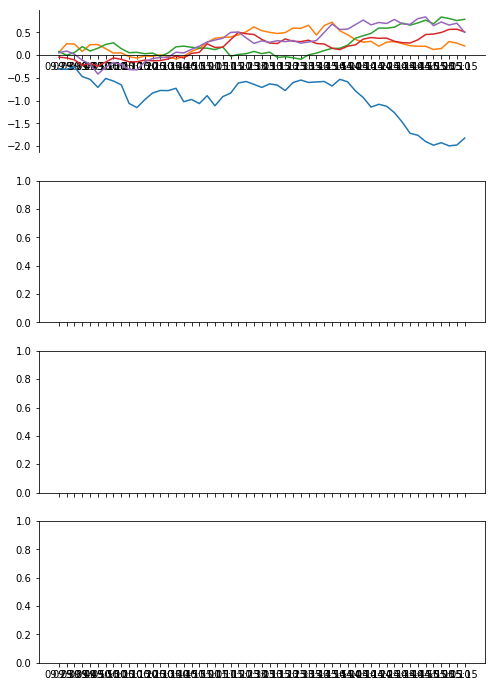

In [18]:
imp_future.imp_minutes_plot()

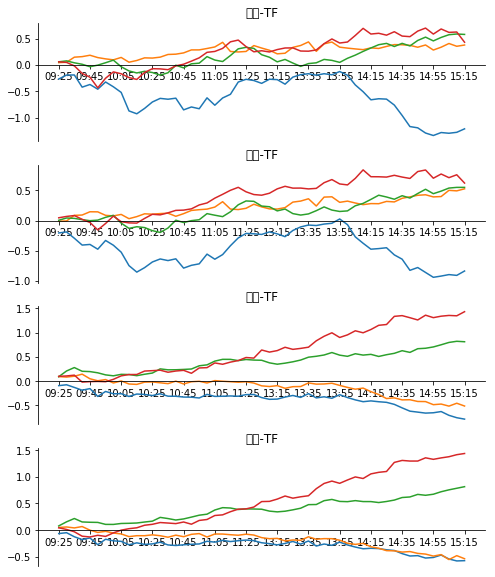

In [102]:
fig, axes = plt.subplots(4, 1, figsize=(8, 10), sharex="all")
xmajorLocator = MultipleLocator(4)
for data, ax in zip(res, axes):
    ax.spines["top"].set_color("none")
    ax.spines["right"].set_color("none")
    ax.xaxis.set_ticks_position("bottom")
    ax.yaxis.set_ticks_position("left")
    #ax.plot(data.index, data, label=["一", "二", "三", "四"])
    ax.plot(data)
    ax.spines["bottom"].set_position(('data', 0))
    ax.xaxis.set_major_locator(xmajorLocator)
    ax.set_title("{}-{}".format("国债", "TF"))

In [9]:
sql1 = """insert into impact 
select t1.dt, t1.code, t2.code0, t1.term, t1.mg_rate-t2.yield, t1.bond_type
from tb_pri t1 inner join tb_sec t2
on t1.code = t2.code and t2.seq=0"""
cur.execute(sql1)


1358

In [11]:
cur.execute("delete from impact")
db.commit()